## kaggle : IEEE_FraudDetection(EDA)
### link : https://www.kaggle.com/competitions/ieee-fraud-detection/overview

In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import warnings
warnings.filterwarnings(action='ignore')


## 데이터 불러오기
### train데이터는 train_transaction과 train_identity를 merge한(on left) CSV파일
### test데이터는 test_transaction과 test_identity를 merge한(on left) CSV파일 

In [2]:
base_path = './data/extracted/'
train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')
# sample_sub = pd.read_csv(base_path + 'sample_submission.csv')


### Head값으로 파일 확인

In [108]:
print(train.head(2))
# print(test.head(2))

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

   C10  C11  C12  C13  C14    D1  D2    D3   D4  D5  D6  D7  D8  D9   D10  \
0  0.0  2.0  0.0  1.0  1.0  14.0 NaN  13.0  NaN NaN NaN NaN NaN NaN  13.0   
1  0.0  1.0  0.0  1.0  1.0   0.0 NaN   NaN  0.0 NaN NaN NaN NaN NaN   0.0   

    D11  D12  D13  D14  D15   M1   M2   M3  M4 M5 M6   M7   M8   M9   V1   V2 

### 전체 컬럼 값 확인

In [109]:
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', 10000)
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7',
       'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17',
       'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37',
       'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57',
       'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67',
       'V6

### merge 축인 TransactionID 값을 index로 지정

In [110]:
train2 = train.set_index('TransactionID')
train2.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

### 결측치 확인

In [111]:
print(train2.info(), train2.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB
None isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 433, dtype: int64


### 불필요한 컬럼 제거 후, 전체 체크 
### C1~V339 컬럼 제거 

In [112]:
train2.columns[train2.columns.str.contains('V')]

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31',
       'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41',
       'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61',
       'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71',
       'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81',
       'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91',
       'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101',
       'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110',
       'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119',
       'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', '

In [113]:
# train[train.columns.drop(list(train.filter(regex='C')))]
# train.filter(regex='C')

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_seq_items', 10000)
sample = train2.drop((train.loc[:,'C1':'V339']), axis=1)
sample

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### EDA파트인 id값만 분리하여 결측치 및 관계 파악
### kaggle내 id_table 컬럼에 대한 정보

Identity Table *
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)
이 테이블의 변수는 네트워크 연결 정보(IP, ISP, Proxy 등)와 트랜잭션과 관련된 디지털 서명(UA/browser/os/version 등)-아이덴티티 정보입니다.
Vesta의 사기 방지 시스템과 디지털 보안 파트너가 수집합니다.
(필드명은 마스킹 처리되며 개인정보 보호 및 계약 동의를 위해 pairwise 사전은 제공하지 않습니다)

“id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C. I hope you could get basic meaning of these features, and by mentioning them as numerical/categorical, you won't deal with them inappropriately.”

“id01 ~ id11은 기기 등급, ip_domain 등급, 프록시 등급 등 Vesta와 보안 파트너가 수집하는 신원에 대한 숫자 기능입니다. 또한 계정 로그인 횟수/로그인 실패 횟수, 계정 기간과 같은 행동 지문을 기록했습니다. 페이지에 머물렀다 등. 이들은 모두 보안 파트너 T&C로 인해 자세히 설명할 수 없습니다. 이러한 기능의 기본적인 의미를 파악하고 수치/범주로 언급하여 부적절하게 다루지 않기를 바랍니다.”

Categorical Features:
-DeviceType
-DeviceInfo
-id_12 ~ id_38

In [114]:
# 샘플 파일의 'id_'가 포함된 열을 기준으로 id_sample 
# sample.isna().sum()
id_sample = sample.filter(regex='id_')
id_sample.isna().sum()

id_01    446307
id_02    449668
id_03    524216
id_04    524216
id_05    453675
id_06    453675
id_07    585385
id_08    585385
id_09    515614
id_10    515614
id_11    449562
id_12    446307
id_13    463220
id_14    510496
id_15    449555
id_16    461200
id_17    451171
id_18    545427
id_19    451222
id_20    451279
id_21    585381
id_22    585371
id_23    585371
id_24    585793
id_25    585408
id_26    585377
id_27    585371
id_28    449562
id_29    449562
id_30    512975
id_31    450258
id_32    512954
id_33    517251
id_34    512735
id_35    449555
id_36    449555
id_37    449555
id_38    449555
dtype: int64

In [115]:
print(id_sample.columns.unique())
print(id_sample.columns.nunique())


Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'],
      dtype='object')
38


In [116]:
#결측치 시각화 라이브러리 
import missingno as msno

<Figure size 720x432 with 0 Axes>

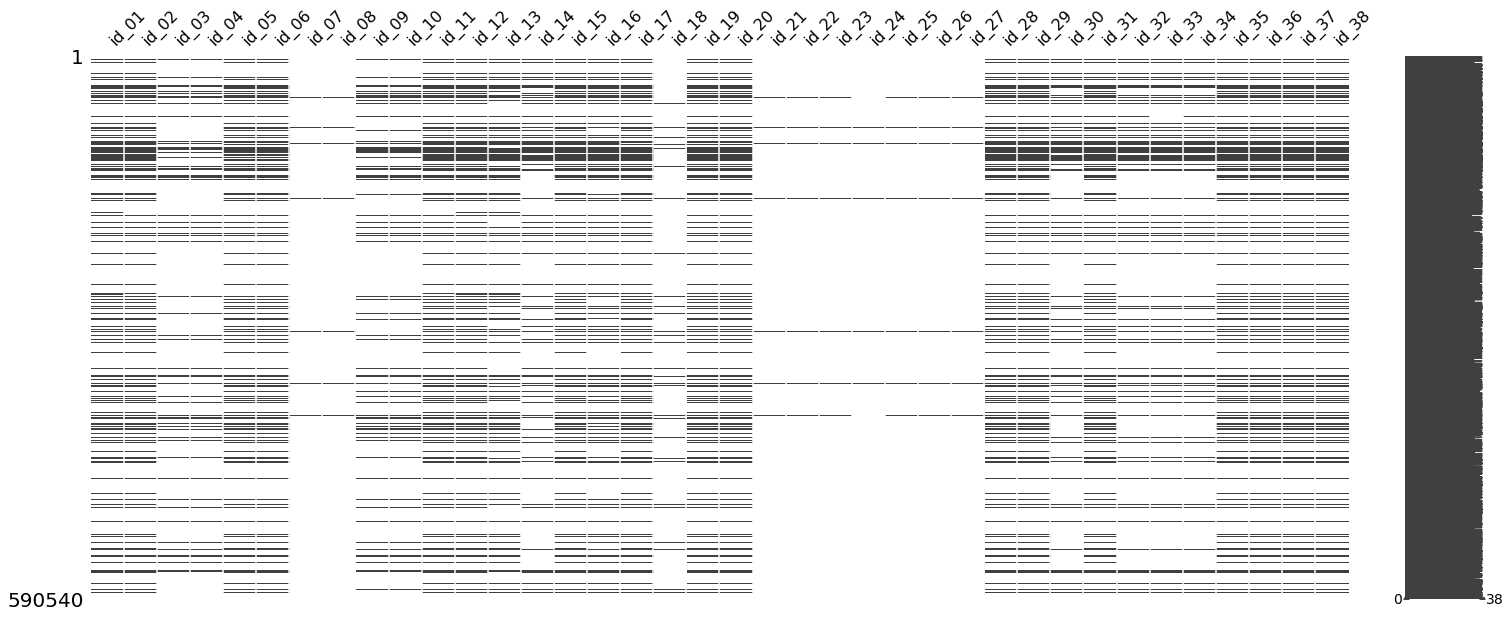

In [117]:
#id_컬럼의 결측치 시각화
plt.figure(figsize=(10,6))
msno.matrix(id_sample)
plt.show()

In [118]:
#id컬럼별 결측치 비율 파악
# (id_sample.isnull().sum()/len(id_sample)).round(2)
null_rate = pd.DataFrame((id_sample.isnull().sum()/len(id_sample)*100).sort_values(ascending=False))
null_rate.columns = ['null_ratio']
null_rate.null_ratio.unique()

array([99.19615945, 99.13096488, 99.12707014, 99.12639279, 99.12571545,
       99.12469943, 92.3607207 , 88.76892336, 87.58949436, 87.31229045,
       86.86541132, 86.86185525, 86.82477055, 86.44562604, 78.4400718 ,
       78.09801199, 76.82375453, 76.41802418, 76.408372  , 76.39973583,
       76.24513157, 76.14522302, 76.12727334, 76.12608799, 75.57608291])

In [119]:
# 1 ='70~80%', 2 ='80~90%', 3 = '90%이상'
# null_rate['level'] = pd.cut(null_rate['null_ratio'] ,3, labels = ['1','2','3'])
# null_rate.groupby(null_rate['level'])
# null_rate.head()

In [124]:
print(id_sample.columns[(id_sample.isnull().sum()/len(id_sample)*100) > 80])
print(id_sample.columns[(id_sample.isnull().sum()/len(id_sample)*100) > 80].nunique())

Index(['id_03', 'id_04', 'id_09', 'id_10', 'id_14', 'id_30', 'id_32', 'id_33',
       'id_34'],
      dtype='object')
9


In [121]:
id_sample.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [122]:
id_sample.drop(['id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25','id_26', 'id_27'], axis=1, inplace=True)
id_sample.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,542.0,144.0,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [123]:
# print(id_sample.describe())
# print('---------------------------------------------------------------')
id_sample.describe(x=object)


TypeError: describe() got an unexpected keyword argument 'x'

### 결측값 발생 유형이 다른 변수와 상관없는 경우로 판단(완전무작위 결측-MCAR)

In [ ]:
# sample.isFraud.isna().sum()
train.isFraud.unique()

array([0, 1])

<AxesSubplot:xlabel='isFraud', ylabel='count'>

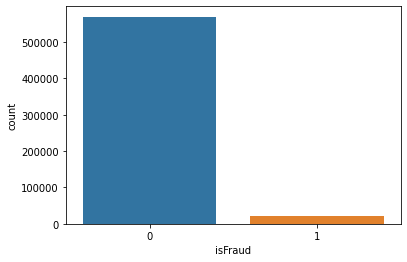

In [ ]:
# sample.isFraud[(sample.isFraud == 0)]
sns.countplot(x="isFraud", data=train)


In [ ]:
# test1 = train[train.isFraud == 0]
# test2 = train[train.isFraud == 1]
# test3 = sample.filter(regex='id_')

# test4 = pd.DataFrame[test1 & test2]
# test5 = pd.DataFrame[test1 & test3]

# plt.figure(figsize=(10,6))
# msno.matrix(test4)
# plt.show()